In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [2]:
NUM_TRADING_DAYS = 252  # Average number of trading days in a year
NUM_PORTFOLIOS = 10000 # Number of random portfolios to simulate

In [6]:
stocks = ['AAPL', 'WMT', 'MSFT', 'GE', 'AMZN', 'DB']

start_date = '2010-01-01'
end_date = '2017-01-01'

In [9]:
def download_data():
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    df = pd.DataFrame(stock_data)
    df.index = pd.to_datetime(df.index)  # Set date as index
    return df

In [11]:
dataset = download_data()
dataset.head()

,AAPL,WMT,MSFT,GE,AMZN,DB
Date,,,,,,
2010-01-04 00:00:00-05:00,6.454506,13.113419,23.347326,53.996010,6.6950,54.430893
2010-01-05 00:00:00-05:00,6.465664,12.982841,23.354862,54.275623,6.7345,55.471489
2010-01-06 00:00:00-05:00,6.362820,12.953820,23.211536,53.996010,6.6125,54.512657
2010-01-07 00:00:00-05:00,6.351058,12.961075,22.970140,56.791939,6.5000,55.129578
2010-01-08 00:00:00-05:00,6.393281,12.895785,23.128557,58.015152,6.6760,57.121590


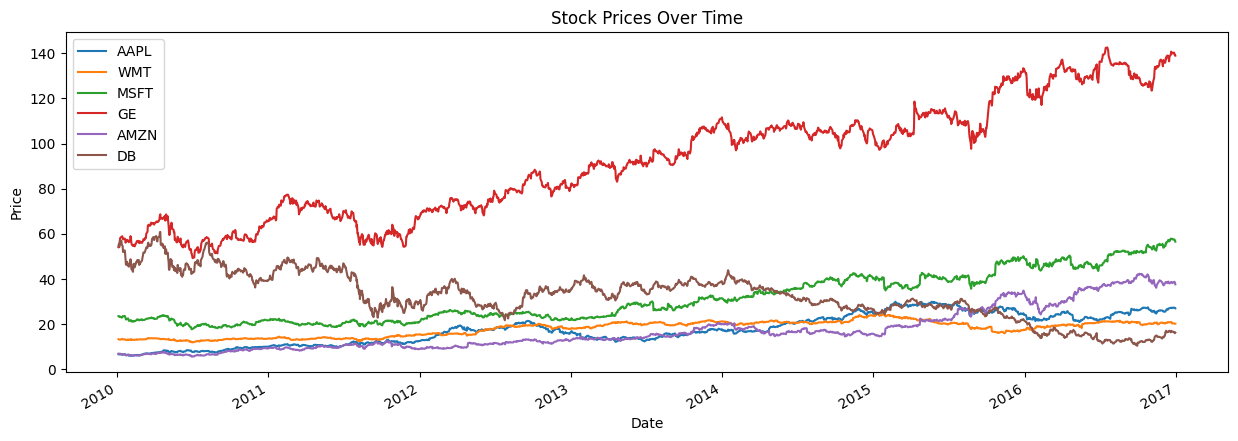

In [13]:
# Function to visualize the stock data
def show_data(data):
    data.plot(figsize=(15, 5))
    plt.title("Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(stocks)
    plt.show()

# Show the stock data
show_data(dataset)


In [15]:
# Function to calculate log returns
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]  # Skip the first row (NaN)

# Calculate log returns
log_daily_returns = calculate_return(dataset)
log_daily_returns.head()  # Show the first few rows of log returns


,AAPL,WMT,MSFT,GE,AMZN,DB
Date,,,,,,
2010-01-05 00:00:00-05:00,0.001727,-0.010007,0.000323,0.005165,0.005883,0.018937
2010-01-06 00:00:00-05:00,-0.016034,-0.002238,-0.006156,-0.005165,-0.018282,-0.017436
2010-01-07 00:00:00-05:00,-0.001850,0.000560,-0.010454,0.050484,-0.017160,0.011253
2010-01-08 00:00:00-05:00,0.006626,-0.005050,0.006873,0.021310,0.026717,0.035496
2010-01-11 00:00:00-05:00,-0.008861,0.016366,-0.012802,0.009592,-0.024335,-0.005611


In [17]:
# Function to display mean and covariance statistics
def show_statistics(returns):
    print("Mean Annual Returns:")
    print(returns.mean() * NUM_TRADING_DAYS)
    print("\nCovariance of Returns:")
    print(returns.cov() * NUM_TRADING_DAYS)

# Show statistics
show_statistics(log_daily_returns)


Mean Annual Returns:
AAPL    0.203962
WMT     0.060359
MSFT    0.126285
GE      0.135330
AMZN    0.246535
DB     -0.174779
dtype: float64

Covariance of Returns:
          AAPL       WMT      MSFT        GE      AMZN        DB
AAPL  0.068795  0.009859  0.023955  0.021861  0.027812  0.036297
WMT   0.009859  0.026701  0.012355  0.013018  0.010755  0.020153
MSFT  0.023955  0.012355  0.053585  0.023986  0.030252  0.042450
GE    0.021861  0.013018  0.023986  0.047376  0.025830  0.054800
AMZN  0.027812  0.010755  0.030252  0.025830  0.104095  0.045055
DB    0.036297  0.020153  0.042450  0.054800  0.045055  0.175733


In [23]:
# Function to calculate portfolio mean and volatility
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected Portfolio Mean (Return): ", portfolio_return)
    print("Expected Portfolio Volatility (Standard Deviation): ", portfolio_volatility)

# Test the function with random weights
weights = np.random.random(len(stocks))
weights /= np.sum(weights)  # Normalize weights
show_mean_variance(log_daily_returns, weights)

Expected Portfolio Mean (Return):  0.08814757412611082
Expected Portfolio Volatility (Standard Deviation):  0.19579597352173103


In [27]:
# Function to visualize portfolios
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(14, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.title("Portfolio Return vs. Volatility")
    plt.show()

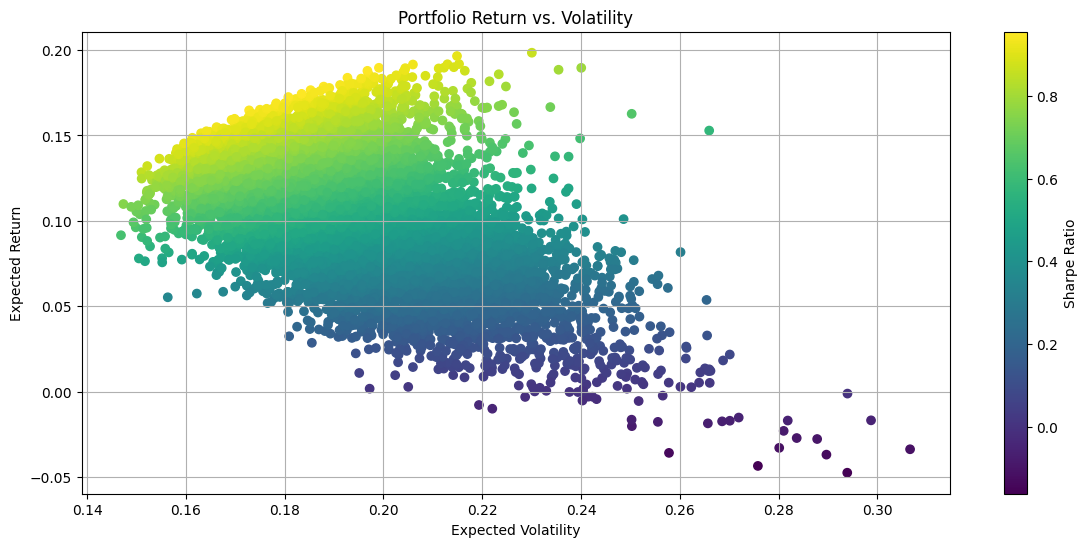

In [29]:
# Generate random portfolios
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)  # Normalize weights
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

# Generate portfolios and show them
pweights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)

In [30]:
# Function to calculate statistics of a portfolio
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Function to minimize the negative Sharpe ratio
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Function to optimize the portfolio
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
    bounds = tuple((0, 1) for _ in range(len(stocks)))  # Bounds for weights
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimize portfolio
optimum = optimize_portfolio(pweights, log_daily_returns)


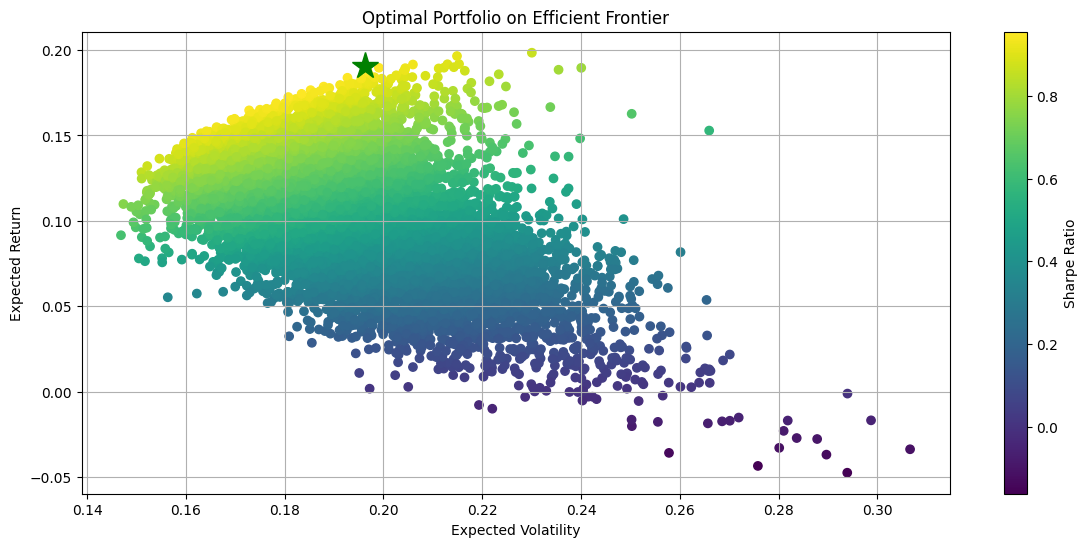

In [33]:
# Function to visualize the optimal portfolio
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(14, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.title("Optimal Portfolio on Efficient Frontier")
    plt.show()

# Show the optimal portfolio
show_optimal_portfolio(optimum, log_daily_returns, means, risks)
